# Analyzing the Correlation Between Inflation and Various Macroeconomic Measures

Ümit Barış Gökkaya - 16.12.2020

## 1. Introduction

Economists always discuss the relationship between inflation and exchange rates and interest rates and so on. Even us engineering students took a few economics courses to understand the factors affecting our economy. In this study, I will try to find a meaningful correlation between inflation, currency rate, unemployment, and interest for Turkey. The main question I am trying to answer is whether we can predict the yearly inflation rate using the aforementioned factors. 

As far as the economic theory is concerned, inflation and interest rates in an economy are directly correlated. [Fisher Equation](https://en.wikipedia.org/wiki/Fisher_equation) states the nominal interest rate in a given period is equal to the sum of real interest rate and inflation rate. I will inspect this equation in Turkish economy and whether it is a good measure for predicting the inflation.

A developing economy, such as Turkey's, is highly dependent on foreign economies and their currency. Because Turkish economy depends on imports and shows a large trade deficit, changes in the USD-TRY exchange rate can correlate to changes in the inflation rate.

As a final point, economist William Phillips developed a theory which describes the relationship between the inflation and unemployment rate in a country. His theory states that greater inflation will decrease unemployment rate in an economy. So called the [Phillips Curve](https://en.wikipedia.org/wiki/Phillips_curve), this inverse relationship can be used to predict the inflation rate.


## 2. Analysis
### a. Data Manipulation and Visualization

All data used in this analysis is from the Central Bank of Turkey’s (TCMB) [EVDS](https://evds2.tcmb.gov.tr/) data center. EVDS provides many different economic statistics related to Turkish and global economy. Most of the data are in time-series format with different frequencies. Because the inflation and unemployment statistics are only available monthly, all data in this analysis will be monthly. Most of the data used will be between January 2015 and September 2020 to keep the analysis relevant.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

In [2]:
evds = pd.read_excel("EVDS.xlsx", names=["date", "interest", "tufe", "unemployment"], 
                     index_col="date", parse_dates=True).dropna()
evds.head()

,interest,tufe,unemployment
date,,,
2005-01-01,18.8050,114.49,10.4
2005-02-01,18.1625,114.51,10.4
2005-03-01,17.1000,114.81,10.0
2005-04-01,16.4840,115.63,9.3
2005-05-01,16.4700,116.69,8.8


After importing the necessary modules, I start by reading the data containing the interest rate, consumer price index (TUFE) and unemployment rate. An economy has many different interest rate measures, the one I chose here is the average interest applied by banks to the deposit accounts. Both the interest and unemployment rates are in percent, to keep the graphs clear, all data will be kept in percentages. 

Unfortunately, there is no yearly inflation data in EVDS. Instead, there is Consumer Price Index data for every month. This index uses 2003 as its base year and computes the average price level across the country. To calculate yearly inflation rates, it is necessary to compare the value to last year's value. 

            interest  unemployment  inflation
date                                         
2020-05-01    7.6540          12.9  11.390017
2020-06-01    7.3825          13.4  12.622392
2020-07-01    7.3440          13.4  11.764145
2020-08-01    8.9750          13.2  11.770410
2020-09-01   10.2875          12.7  11.748314


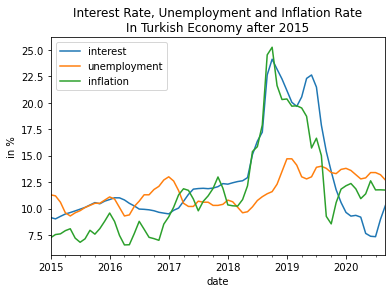

In [3]:
evds["inflation"] = (evds.tufe / evds.tufe.shift(12) - 1) * 100  # yearly inflation
evds = evds.drop("tufe", axis=1)

post2015 = evds.loc["2015":]
print(post2015.tail())
post2015.plot(title="Interest Rate, Unemployment and Inflation Rate\nIn Turkish Economy after 2015", ylabel="in %");

After calculating the inflation rate, data that was collected before 2015 are dropped. Looking at the value for September 2020 and comparing it to the value reported by TUIK, it can be assumed that the inflation rate calculations were correct.

Plotting the data from 2015 onwards shows the great level of correlation between inflation and interest rates, but the unemployment rate does not correlate that well. It also shows some seasonality, which will not be corrected in this analysis.

Now we look at the exchange rate between US dollars and Turkish liras.

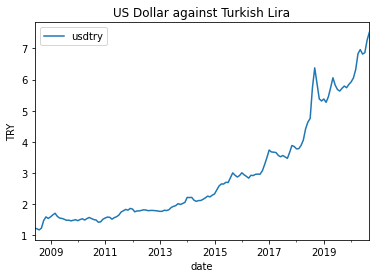

In [4]:
usd = pd.read_excel("dolar.xlsx", names=["date", "usdtry"], parse_dates=True, 
                    index_col="date")
usd.plot(title="US Dollar against Turkish Lira", ylabel="TRY")
plt.legend(loc="upper left");

The exchange rate seems to have an overall trend of increase, with no apparent seasonal effect. However, it appears to be volatile, going up and down at seemingly random intervals.

Both inflation and interest rates measure some change. For a better analysis, instead of using the level of the exchange rate, it may be better to use relative change from month to month. Also as mentioned, Turkish lira is not very stable and shows great volatility. To counteract this, a smoothening method can be used. I chose moving average with a period of 1 year to smooth out the volatility. The resulting data is plotted below.

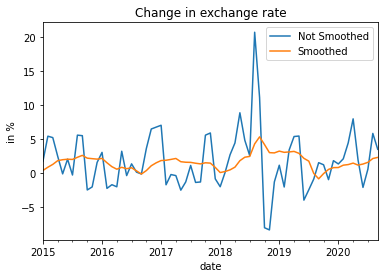

In [5]:
usd["lagged"] = usd.shift(1)
usd["change_in_currency"] = (usd.usdtry - usd.lagged) / usd.lagged * 100
usd["smoothed_change"] = usd.change_in_currency.rolling(12).mean()

usd = usd.loc["2015":].drop(["lagged", "usdtry"], axis=1)
usd.plot(title="Change in exchange rate", ylabel="in %")
plt.legend(["Not Smoothed", "Smoothed"]);

### b. Correlation Analysis 

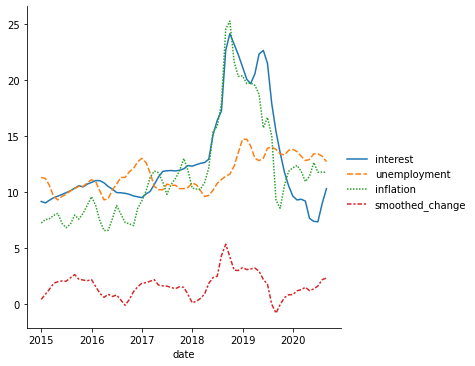

In [6]:
df = pd.merge(post2015, usd.smoothed_change, on="date")
sns.relplot(data=df, kind="line");

Looking at the above graph, there seems to be some level of correlation in our data. To see this in numbers, a correlation matrix is calculated and visualized using a heatmap.

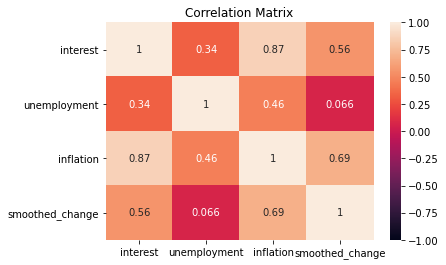

In [7]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True).set_title("Correlation Matrix");

As predicted before, the highest correlation is between the interest rate and the inflation. Unemployment and inflation have a positive correlation. To visualize the correlations better, pairwise scatter plots for all the data are used.

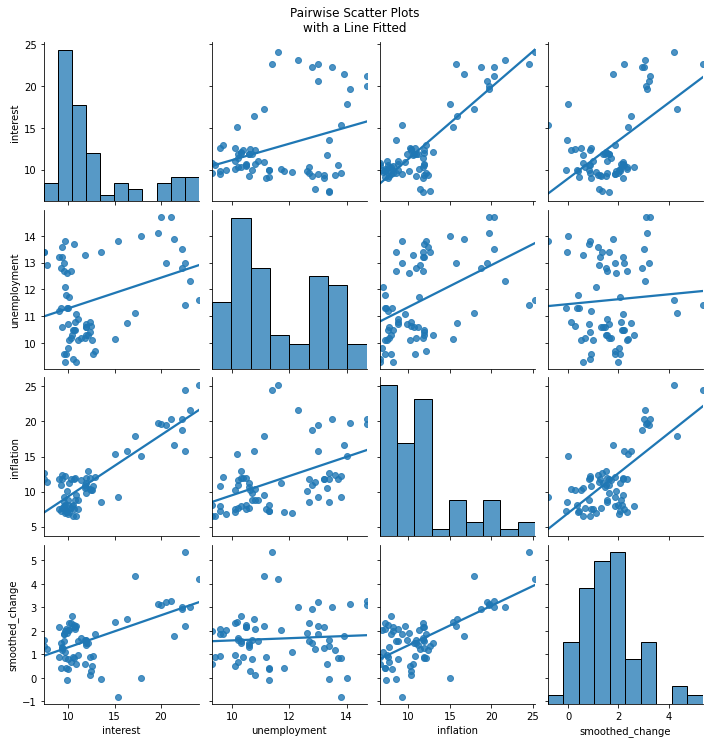

In [8]:
sns.pairplot(df, x_vars=df.columns, y_vars=df.columns, 
             kind="reg", plot_kws={"ci":False}).fig.suptitle("Pairwise Scatter Plots\nwith a Line Fitted", y=1.03);

As we can see, the best variable to be predicted seems to be the inflation rate. Both the change in currency and the interest rate show a high level of correlation and although contradicting Phillips curve, unemployment also has some level of correlation with the inflation.

A multiple linear regression model is fitted to our data using ordinary least squares method. 

In [9]:
model = ols(formula="inflation ~ interest + unemployment + smoothed_change", 
            data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     137.6
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           4.25e-28
Time:                        22:59:18   Log-Likelihood:                -132.66
No. Observations:                  69   AIC:                             273.3
Df Residuals:                      65   BIC:                             282.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -6.5911      1.600     

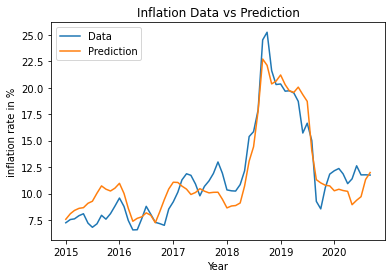

In [10]:
plt.plot(df.index, df.inflation, label="Data")
plt.plot(df.index, model.predict(), label="Prediction")
plt.legend(loc="upper left")
plt.title("Inflation Data vs Prediction")
plt.ylabel("inflation rate in %")
plt.xlabel("Year");

Looking at the model, an R<sup>2</sup> score of 0.858 is not a bad one, especially considering that we are predicting the inflation, a major macroeconomic statistic, using only 3 measures. All the factors are statistically significant (p-value less than 0.001), meaning that they indeed influence the inflation rate.

The graphic compares the model with the real data and seems to fit nicely. 

## 3. Conclusion

Returning to my main question, it is indeed possible to estimate the yearly inflation rate to some degree using the interest rate, unemployment level and the change in exchange rate. 

Further improvements to the model can be done by adjusting the seasonality of the unemployment data. Another possible problem in the model is the lack of "force majeure". The Pastor Brunson Crisis in mid-2018 or Covid-19 pandemic are very hard to incorporate into the model.

However, because we are dealing with the economy of a country involving thousands of different factors, it may be the best to leave this to economic theorists, who can better explain why the unemployment and inflation dilemma mentioned by the Phillips Curve is not reflected in the case of Turkish economy.

## 4. References

Source for the data: [EVDS](evds2.tcmb.gov.tr)

Jupyter Notebook for this analysis: [IE 360 Homework 2](ie360_hw2.ipynb)

Excel Files used in this analysis: [Interest rate, CPI and Unemployment](EVDS.xlsx), [USDTRY Exchange Rate](dolar.xlsx)